## Part 2: Finetuning pretrained CNN on the downstream task
In this part, you will finetune a pretrained CNN model to another task. Finetuning is powerful with the following strengths:
1. **Faster training** : It starts with pre-trained weights which allow the model to converge faster than training from scratch.
2. **Domain Adaptation** : Fine-tuning is effective for adapting a model trained on one domain to another.
3. **Transfer Learning**...and more

In this part, you will finetune on BDD weather classifcation dataset, more details here: https://www.kaggle.com/datasets/marquis03/bdd100k-weather-classification

### Tasks
1. Follow the steps and complete your finetuning procedure
2. Compare the training/val loss/accuracy curve between training from scratch and finetuning
3. Plot the confusion matrix for two cases

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Subset
from torch import Tensor
from typing import Type

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
import pdb

import kagglehub

### [0 points] Step 1: Download the BDD100K weather classification dataset from Kaggle
Please DO NOT modify this cell.

In [2]:
# Download BDD weather classification dataset
base_dir = kagglehub.dataset_download("marquis03/bdd100k-weather-classification")
print("Path to dataset files:", base_dir)
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'val')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Path to dataset files: C:\Users\partho.ghose\.cache\kagglehub\datasets\marquis03\bdd100k-weather-classification\versions\1


### [5 points] Step 2: Create the data loader, and split it to train/val

Basically this step is the same as you did in Part 1.
Remember to change the ```num_classes``` to 7, and we will only train for 10 epochs.

1. The original folder structure is: \
   ├── train \
│   ├── labels (such as clear, foggy...) \
│   │   ├── *****.jpg \
│   │   ├── *****.jpg \
│   │   ├── ... \
   It is highly recommended to use ```dataset.ImageFolder``` to load the data!
2. To check how to transform your data, check here: https://pytorch.org/vision/main/transforms.html
3. Later when you train the model, you might need to tune hyperparameters. For example, you may not want the fixed learning rate.


In [3]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Parameters
img_size = 64

# Hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 10
num_classes = 7

# Data transformations with augmentation for training set
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    # transforms.RandomRotation(degrees=15),  # Slight rotation augmentation
    # transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transformations (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset loading with transformations
dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)

# Split train and validation datasets
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Apply the transformation for validation dataset (no augmentation)
val_dataset.dataset.transform = val_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Example of iterating through the training loader
for images, labels in train_loader:
    print(f"Batch image size: {images.size()}")
    print(f"Batch label size: {labels.size()}")
    break


Training set size: 55890
Validation set size: 13973
Batch image size: torch.Size([32, 3, 64, 64])
Batch label size: torch.Size([32])


### [5 points] Step 3: Copy your CNN model and training function in Part 1 after this cell

In [4]:
### Define the custom CNN model
class yourCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(yourCNN, self).__init__()
        # Conv layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second conv block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third conv block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Fourth conv block
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [23]:
### Define the model
model = yourCNN(num_classes=num_classes).to(device)
print(model)


### Define the Loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer =optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


yourCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

In [5]:
import torch

### Training function
def train_model(model, train_loader, val_loader, criterion, optimizer,scheduler, num_epochs=num_epochs, device='cuda'):
    # Move the model to the correct device
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Iterate through each batch in the training data loader
        for inputs, labels in train_loader:
            # Move inputs and labels to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # Backpropagation
            loss.backward()

            # Update the model's parameters
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy for this epoch
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No gradients needed during validation
            for inputs, labels in val_loader:
                # Move inputs and labels to the same device as the model
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Calculate the loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy for this epoch
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies, model


### [15 points] Step 4: Compare the difference of finetuning from pretrained model and training from scratch
1. You will need to finetune two models. The first is the model trained from scratch with the BDD dataset, and another is finetuning from pretrained model.
2. For training from scratch, it is almost the same procedure as in Part 1, but the dataset changes.
3. For finetuning, the procedure is:
   * Initialize the model and load the pretrained model using ```torch.load()```, remember that we saved the trained model in Part 1!
   * The output of original CNN is 200 classes, you might need to reinitialize the model to output 7 classes by replacing the last fc layer
   * More details : https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

### [0 points] Step 5: Start training the model!

Epoch [1/10], Train Loss: 1.0400, Train Accuracy: 64.76%, Val Loss: 0.9590, Val Accuracy: 67.05%
Epoch [2/10], Train Loss: 0.9316, Train Accuracy: 68.09%, Val Loss: 0.8956, Val Accuracy: 69.11%
Epoch [3/10], Train Loss: 0.8810, Train Accuracy: 69.86%, Val Loss: 0.8610, Val Accuracy: 70.42%
Epoch [4/10], Train Loss: 0.8473, Train Accuracy: 71.35%, Val Loss: 0.8359, Val Accuracy: 71.84%
Epoch [5/10], Train Loss: 0.8224, Train Accuracy: 72.08%, Val Loss: 0.8033, Val Accuracy: 72.85%
Epoch [6/10], Train Loss: 0.8007, Train Accuracy: 72.75%, Val Loss: 0.8244, Val Accuracy: 72.17%
Epoch [7/10], Train Loss: 0.7799, Train Accuracy: 73.51%, Val Loss: 0.7834, Val Accuracy: 73.56%
Epoch [8/10], Train Loss: 0.7674, Train Accuracy: 73.71%, Val Loss: 0.7987, Val Accuracy: 73.16%
Epoch [9/10], Train Loss: 0.7506, Train Accuracy: 74.52%, Val Loss: 0.7907, Val Accuracy: 74.06%
Epoch [10/10], Train Loss: 0.7356, Train Accuracy: 74.99%, Val Loss: 0.8444, Val Accuracy: 70.29%


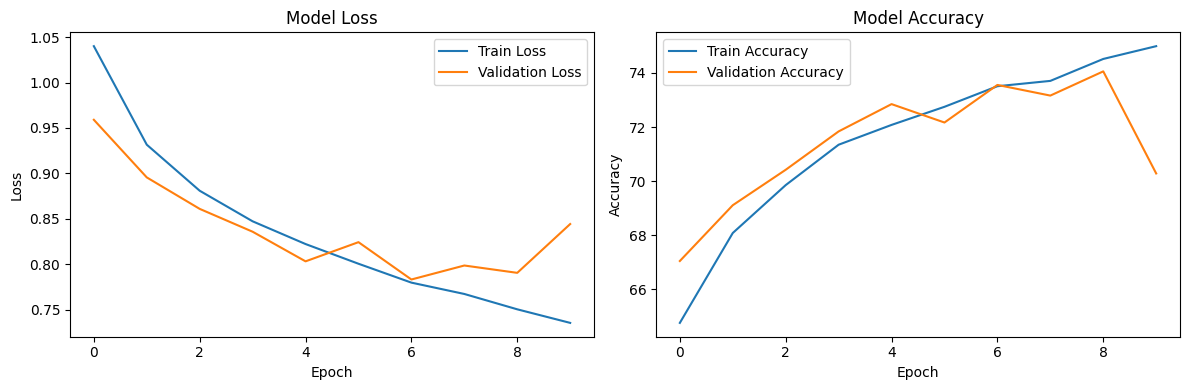

In [8]:
### Train the model
train_losses, val_losses, train_accuracies, val_accuracies, model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

### We will save the model, in part 2 we gonna use it!

# Define the full path where the model weights will be saved
model_path = os.path.join('C:/Users/partho.ghose/Desktop/Project/Segment/CV2', 'CNN_weights_full_Weather_dataset.pth')


# Save the model weights
torch.save(model.state_dict(), model_path)

### Plot results. This is a naive plot, you are encouraged to improve it!
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Compute and print the average training and validation accuracy
avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Average Training Accuracy: 71.56%
Average Validation Accuracy: 71.45%


### [5 points] Step 6: Evaluate your model on testing set and plot the confusion matrix
In this part, you will learn to evaluate a trained model on testing set, and plot the confusion matrix.
Ideally, a great classification model would have non-zero values only along the diagonal, with zeros in all off-diagonal elements.

**HINTS**
1. Remember to perform the same transforms to your testing set as the validation set.
2. In ```get_predictions```, it is basically the same as you do evaluation.

In [20]:

#  transformations (no augmentation)
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Apply transformation to test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Define test loader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

print(f"Test dataset size: {len(test_dataset)}")


Test dataset size: 10000


Confusion Matrix:
[[4714    0   61   32   85  379   75]
 [   8    0    1    0    3    1    0]
 [ 221    0  754   71   82   26   85]
 [ 302    0  121  287    7   12    9]
 [ 136    0   80    1  436   52   33]
 [ 286    0   37   12   59  321   54]
 [ 192    0  251    2  101   37  574]]
Test Accuracy: 0.7086


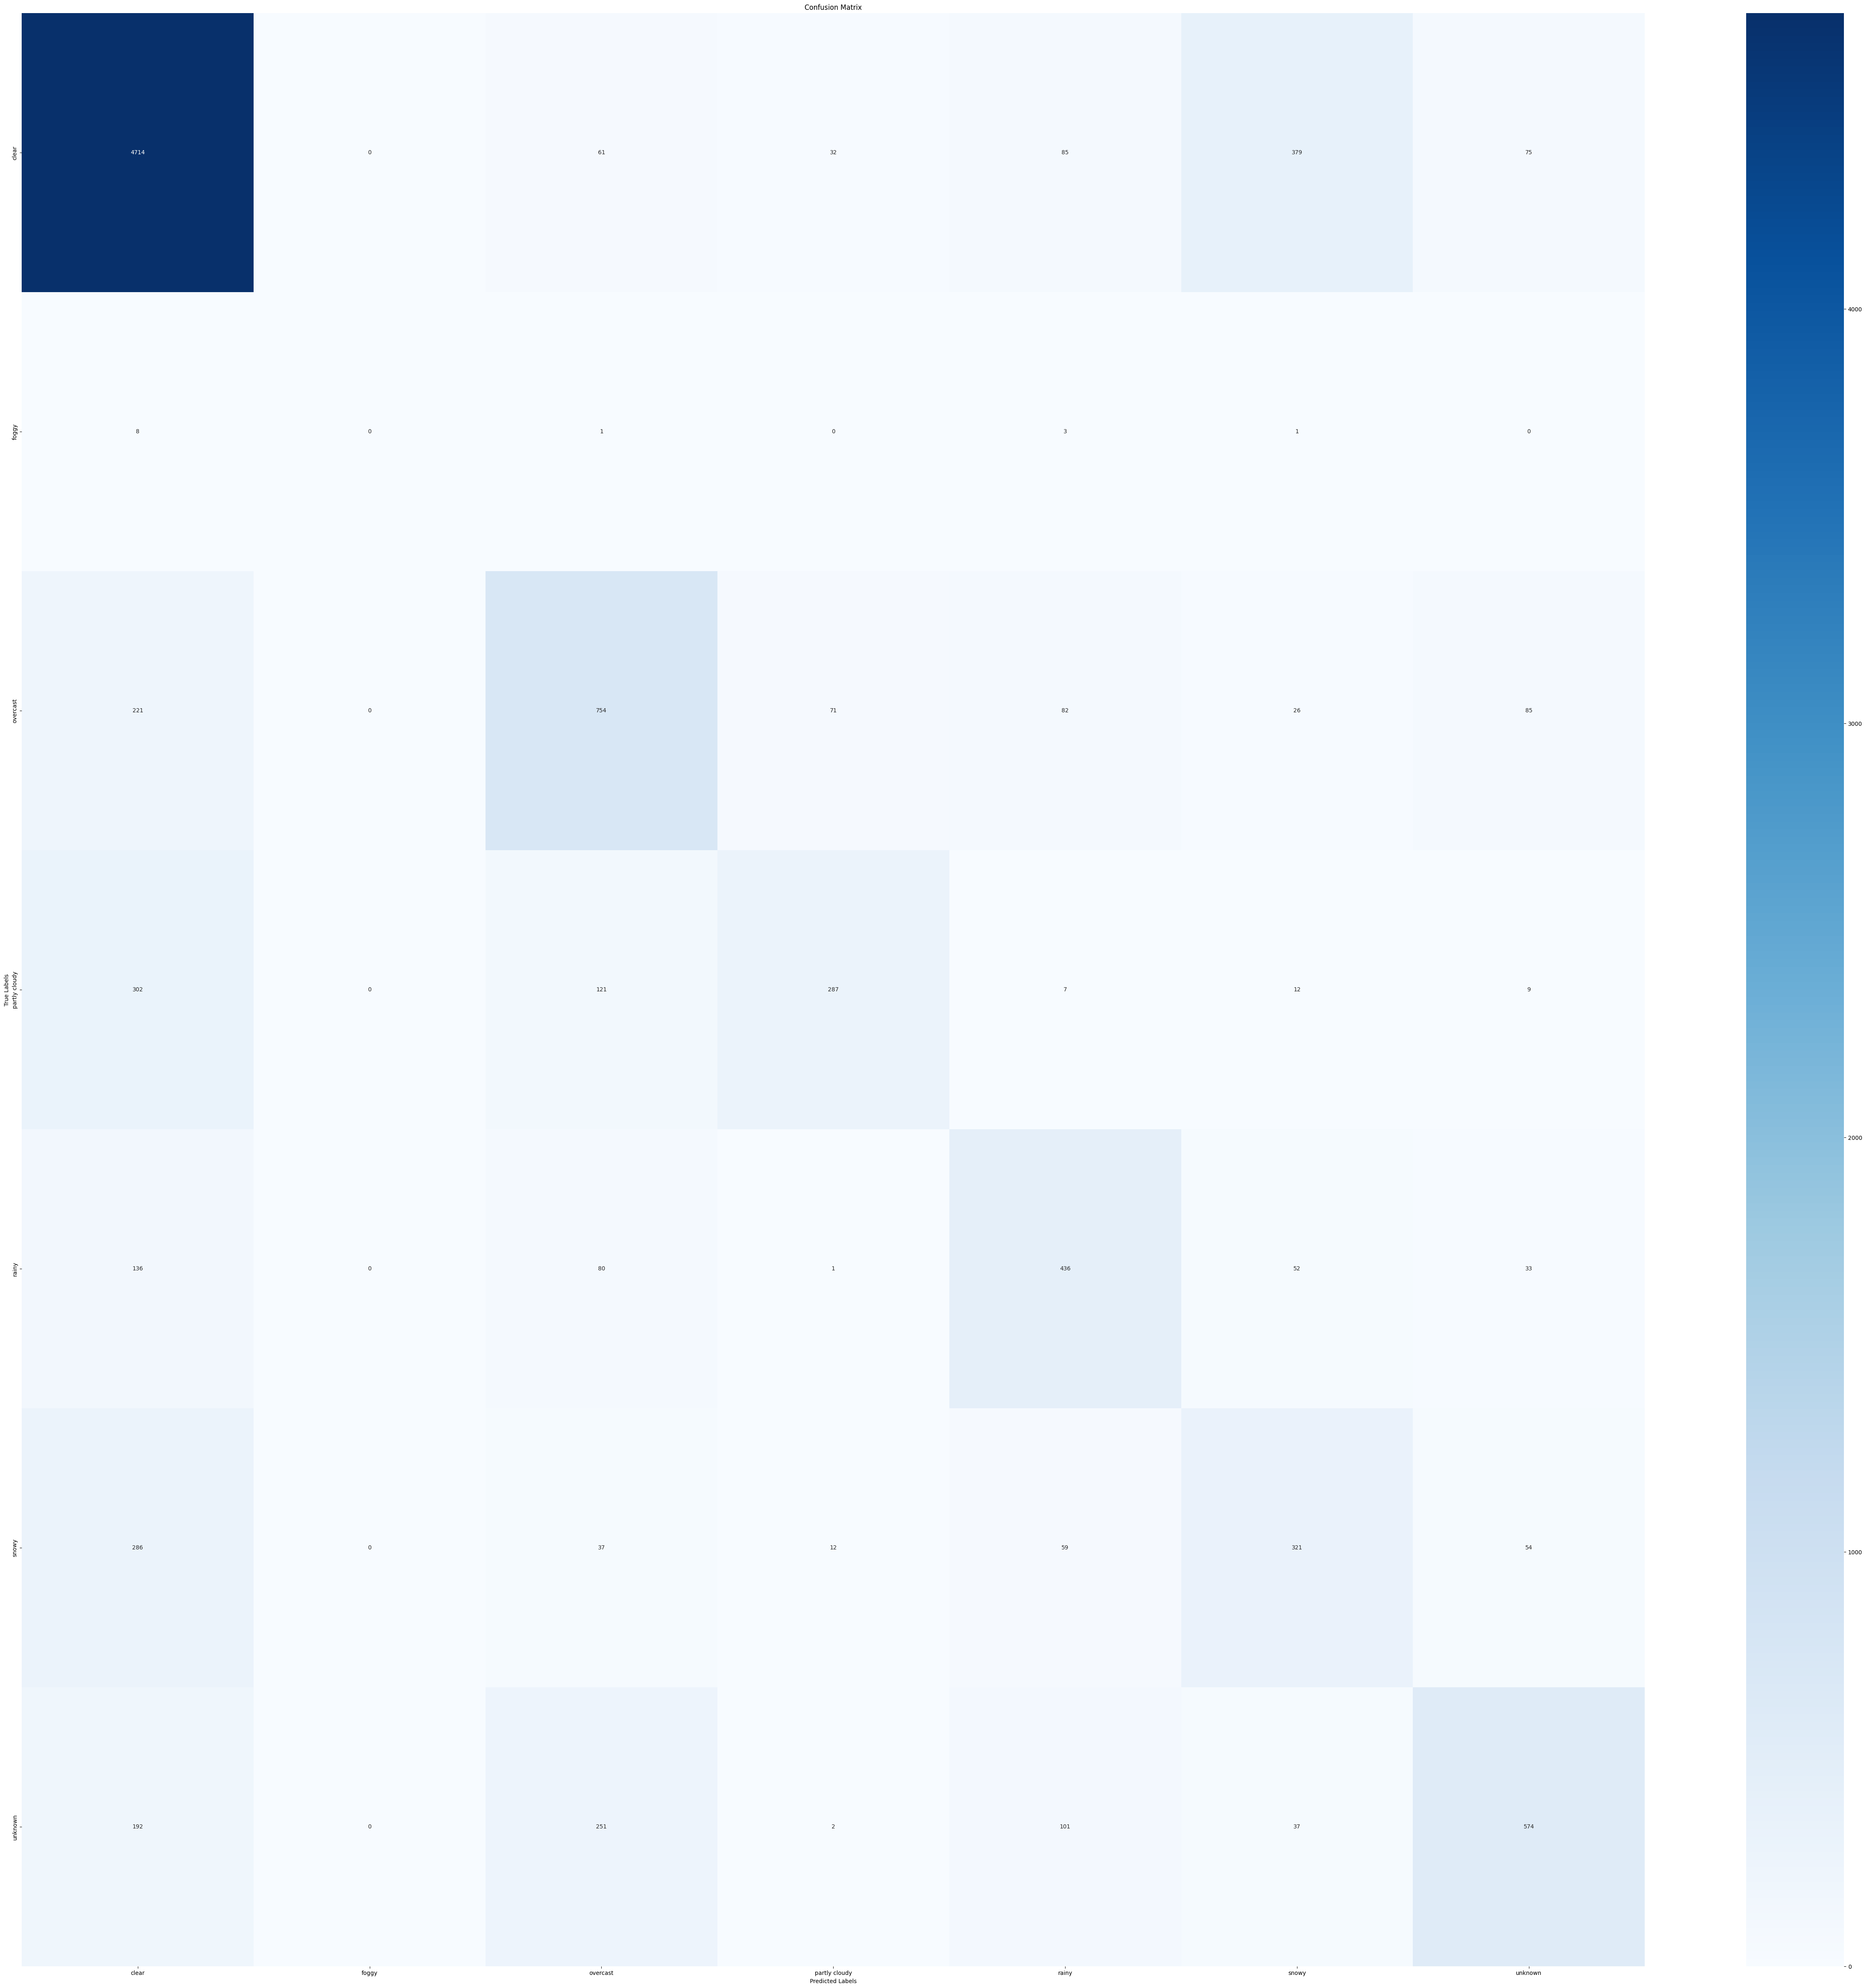

In [11]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

### If you don't want to train the model again, you can restore it
#model.load_state_dict(torch.load(r"C:/Users/partho.ghose/Desktop/Project/Segment/CV/CNN_weights_full_Weather_dataset.pth"))
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class index with max probability

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

### Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader)

################# Compute confusion matrix ##################
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

### Plot Confusion Matrix (Optional for Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Access the classes from the original dataset (train_dataset)
plt.figure(figsize=(64, 62))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [13]:
# Per-class Performance
class_names = test_dataset.classes  # Ensure 'test_dataset' is correctly defined
print("\nPer-class Performance:")
for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() != 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name:15} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Per-class Performance:
clear           - Precision: 0.805, Recall: 0.882, F1: 0.841
foggy           - Precision: 0.000, Recall: 0.000, F1: 0.000
overcast        - Precision: 0.578, Recall: 0.609, F1: 0.593
partly cloudy   - Precision: 0.709, Recall: 0.389, F1: 0.502
rainy           - Precision: 0.564, Recall: 0.591, F1: 0.577
snowy           - Precision: 0.388, Recall: 0.417, F1: 0.402
unknown         - Precision: 0.692, Recall: 0.496, F1: 0.578


Fine Tuning

In [11]:
#Fine tuned Model
import torch
import torch.nn as nn
import torch.optim as optim

# Load the model
pretrained_weights_path = r"C:\Users\partho.ghose\Desktop\Project\Segment\CV2\CNN_weights_full_dataset.pth"
model_finetune = yourCNN(num_classes=200)

# Load only weights to avoid untrusted pickle loading
model_finetune.load_state_dict(torch.load(pretrained_weights_path, weights_only=True))

# Modify the last fully connected layer
in_features = model_finetune.classifier[-1].in_features  # Accessing last Linear layer
model_finetune.classifier[-1] = nn.Linear(in_features, 7)  # Replace last layer with new output classes

# # Optional: Freeze earlier layers if you only want to finetune the final layer
# for name, param in model_finetune.named_parameters():
#     if "classifier" not in name:  # Freezing all layers except the classifier
#         param.requires_grad = False


# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_finetune = model_finetune.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model_finetune.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Print model to check changes
print(model_finetune)


yourCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

Epoch [1/10], Train Loss: 1.0428, Train Accuracy: 64.49%, Val Loss: 1.0175, Val Accuracy: 63.18%
Epoch [2/10], Train Loss: 0.9367, Train Accuracy: 67.79%, Val Loss: 0.8859, Val Accuracy: 69.93%
Epoch [3/10], Train Loss: 0.8880, Train Accuracy: 69.68%, Val Loss: 0.8800, Val Accuracy: 69.73%
Epoch [4/10], Train Loss: 0.8538, Train Accuracy: 71.08%, Val Loss: 0.8507, Val Accuracy: 71.00%
Epoch [5/10], Train Loss: 0.8257, Train Accuracy: 71.81%, Val Loss: 0.8279, Val Accuracy: 72.61%
Epoch [6/10], Train Loss: 0.8075, Train Accuracy: 72.51%, Val Loss: 0.7818, Val Accuracy: 73.62%
Epoch [7/10], Train Loss: 0.7876, Train Accuracy: 73.05%, Val Loss: 0.7665, Val Accuracy: 73.86%
Epoch [8/10], Train Loss: 0.7710, Train Accuracy: 73.72%, Val Loss: 0.7574, Val Accuracy: 74.26%
Epoch [9/10], Train Loss: 0.7565, Train Accuracy: 74.42%, Val Loss: 0.7793, Val Accuracy: 73.68%
Epoch [10/10], Train Loss: 0.7423, Train Accuracy: 74.62%, Val Loss: 0.7751, Val Accuracy: 74.84%


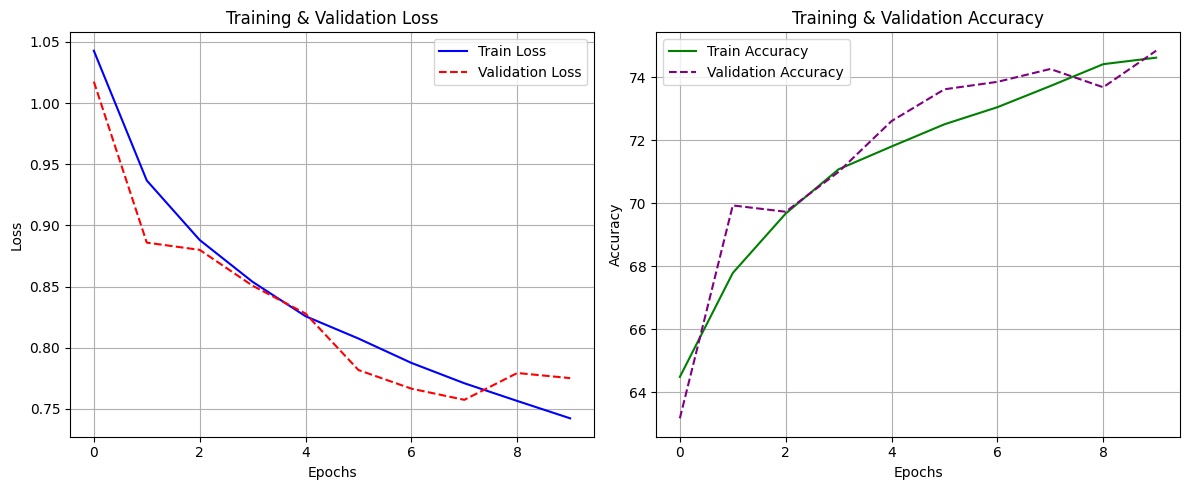

In [12]:
# Train the fine-tuned model
train_losses, val_losses, train_accuracies, val_accuracies, trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# Save the fine-tuned model weights
model_save_path = r"C:/Users/partho.ghose/Desktop/Project/Segment/CV2/CNN_weights_full_Weather_Tuned.pth"
torch.save(trained_model.state_dict(), model_save_path)

# Plot training and validation results
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue", linestyle="-")
plt.plot(val_losses, label="Validation Loss", color="red", linestyle="--")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green", linestyle="-")
plt.plot(val_accuracies, label="Validation Accuracy", color="purple", linestyle="--")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [13]:
# Compute and print the average training and validation accuracy
avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Average Training Accuracy: 71.32%
Average Validation Accuracy: 71.67%


Confusion Matrix:
[[4980    0   72   47   16   98  133]
 [   7    0    1    0    3    1    1]
 [ 137    0  735   67   26   37  237]
 [ 225    0  147  310    1   24   31]
 [ 206    0   92    2  298   44   96]
 [ 372    0   35   14   17  241   90]
 [ 124    0   95    3   12   24  899]]
Test Accuracy: 0.7463


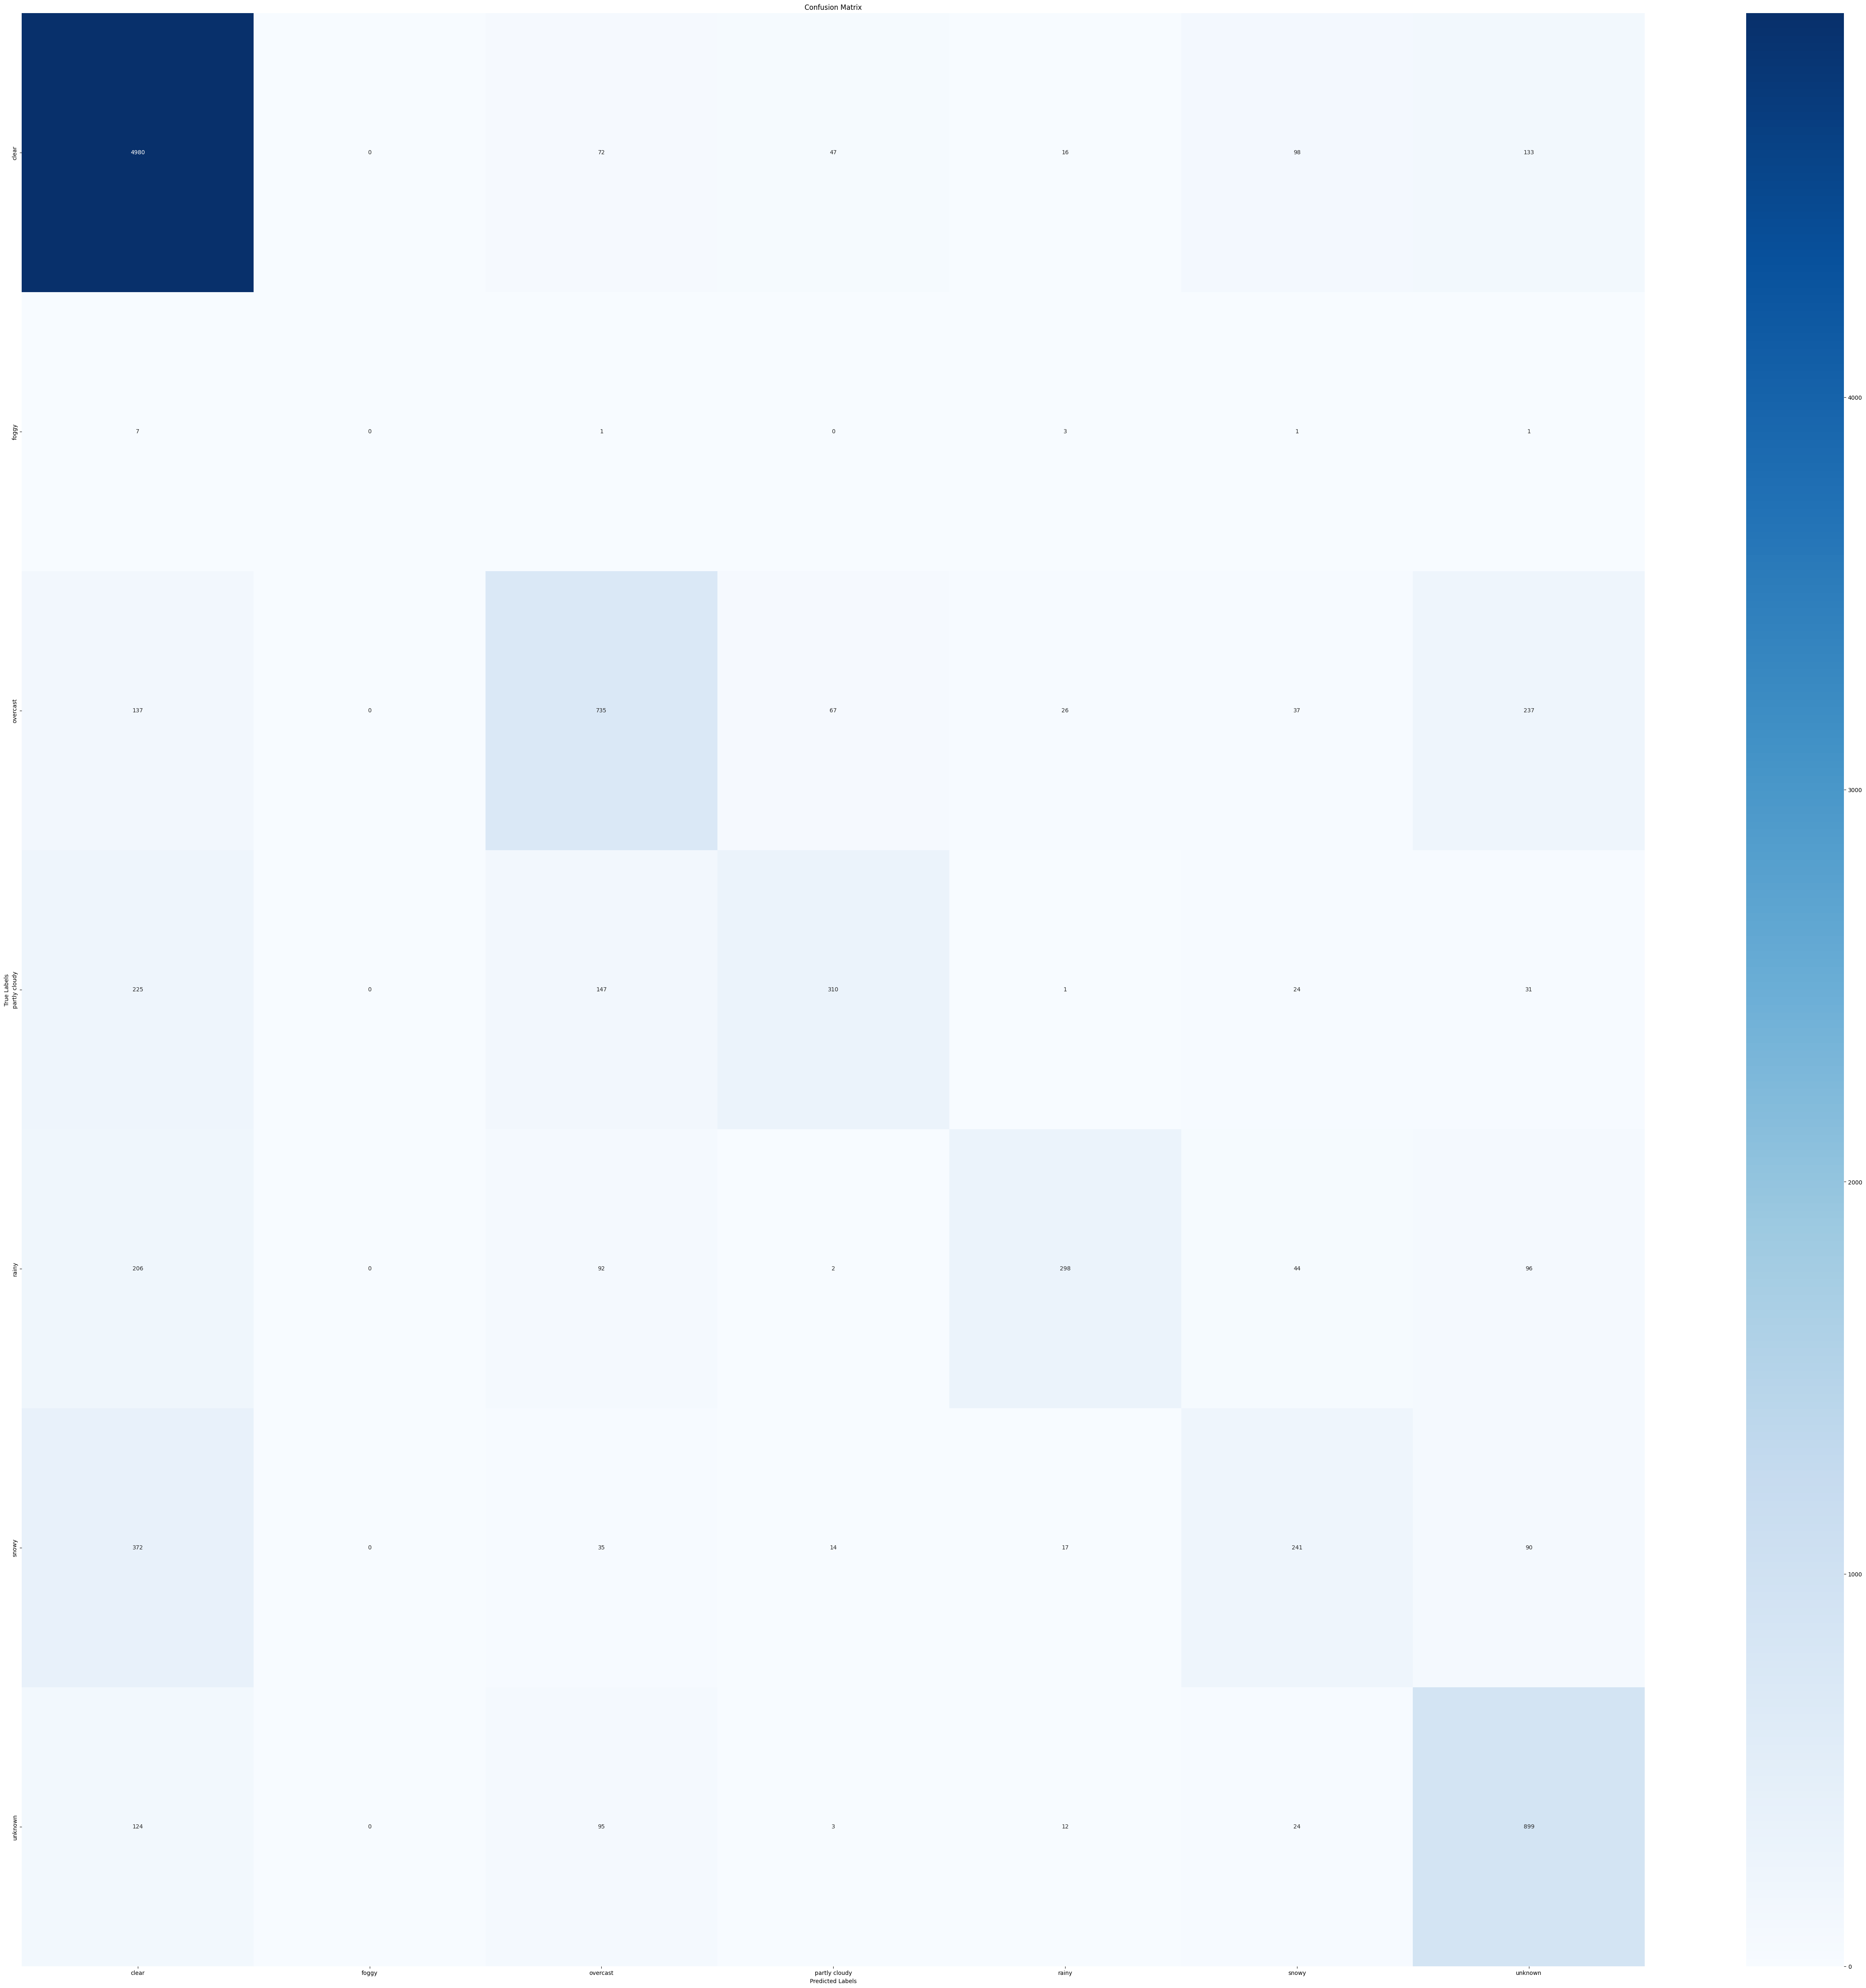

In [16]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

### If you don't want to train the model again, you can restore it
model.load_state_dict(torch.load(r"C:/Users/partho.ghose/Desktop/Project/Segment/CV/CNN_weights_full_Weather_Tuned.pth"))
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class index with max probability

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

### Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader)

################# Compute confusion matrix ##################
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

### Plot Confusion Matrix (Optional for Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Access the classes from the original dataset (train_dataset)
plt.figure(figsize=(64, 62))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [17]:
# Per-class Performance
class_names = test_dataset.classes  # Ensure 'test_dataset' is correctly defined
print("\nPer-class Performance:")
for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() != 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name:15} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Per-class Performance:
clear           - Precision: 0.823, Recall: 0.932, F1: 0.874
foggy           - Precision: 0.000, Recall: 0.000, F1: 0.000
overcast        - Precision: 0.624, Recall: 0.593, F1: 0.608
partly cloudy   - Precision: 0.700, Recall: 0.420, F1: 0.525
rainy           - Precision: 0.799, Recall: 0.404, F1: 0.536
snowy           - Precision: 0.514, Recall: 0.313, F1: 0.389
unknown         - Precision: 0.605, Recall: 0.777, F1: 0.680


**For Freeze layer**

In [6]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned model
pretrained_weights_path = r"C:\Users\partho.ghose\Desktop\Project\Segment\CV2\CNN_weights_full_dataset.pth"
model_finetune_freeze = yourCNN(num_classes=200)  # Initialize model architecture

# Load only weights to avoid untrusted pickle execution
model_finetune_freeze.load_state_dict(torch.load(pretrained_weights_path, weights_only=True))
model_finetune_freeze.to(device)

# Freeze all layers except the last fully connected layer
for param in model_finetune_freeze.parameters():
    param.requires_grad = False  # Freeze all layers

# Modify the last fully connected layer
in_features = model_finetune_freeze.classifier[-1].in_features
model_finetune_freeze.classifier[-1] = nn.Linear(in_features, 7)  # Update to 7 classes

# Unfreeze the last fully connected layer
for param in model_finetune_freeze.classifier[-1].parameters():
    param.requires_grad = True

model_finetune_freeze.to(device)  # Move updated model to device

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model_finetune_freeze.classifier[-1].parameters(), lr=0.001)  # Only optimize last layer
optimizer = optim.SGD(model_finetune_freeze.classifier[-1].parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Print model to check changes
print(model_finetune_freeze)

yourCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, a

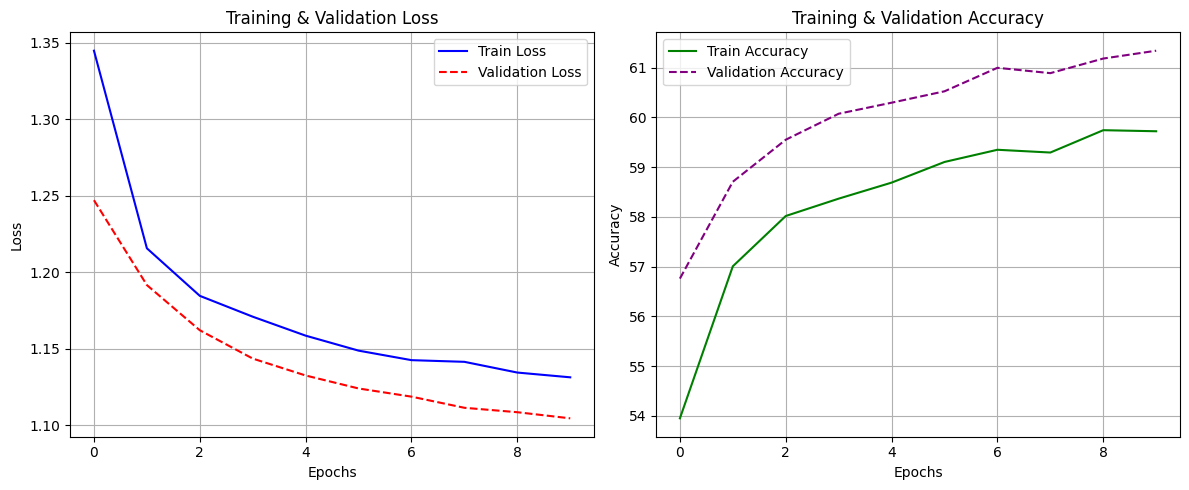

In [16]:
# Train the fine-tuned model
#train_losses, val_losses, train_accuracies, val_accuracies, trained_finetune_freeze = train_model(
#    model_finetune_freeze, train_loader, val_loader, criterion, optimizer, scheduler
#)

# Save the fine-tuned model weights
model_save_path = r"C:\Users\partho.ghose\Desktop\Project\Segment\CV2\CNN_weights_full_Weather_Freeze.pth"
torch.save(trained_finetune_freeze.state_dict(), model_save_path)

# Plot training and validation results
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="blue", linestyle="-")
plt.plot(val_losses, label="Validation Loss", color="red", linestyle="--")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="green", linestyle="-")
plt.plot(val_accuracies, label="Validation Accuracy", color="purple", linestyle="--")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [17]:
# Compute and print the average training and validation accuracy
avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
avg_val_accuracy = sum(val_accuracies) / len(val_accuracies)

print(f"Average Training Accuracy: {avg_train_accuracy:.2f}%")
print(f"Average Validation Accuracy: {avg_val_accuracy:.2f}%")


Average Training Accuracy: 58.32%
Average Validation Accuracy: 60.03%


C:\Users\partho.ghose\AppData\Local\Temp\ipykernel_20184\1261171871.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(r"C:/Users/partho.gh

Confusion Matrix:
[[5136    0  121    0    0    0   89]
 [   7    0    4    0    1    0    1]
 [ 570    0  541    0    8    0  120]
 [ 590    0  117    0    1    0   30]
 [ 446    0  174    0   47    0   71]
 [ 623    0   78    0    1    2   65]
 [ 626    0  114    0   10    0  407]]
Test Accuracy: 0.6133


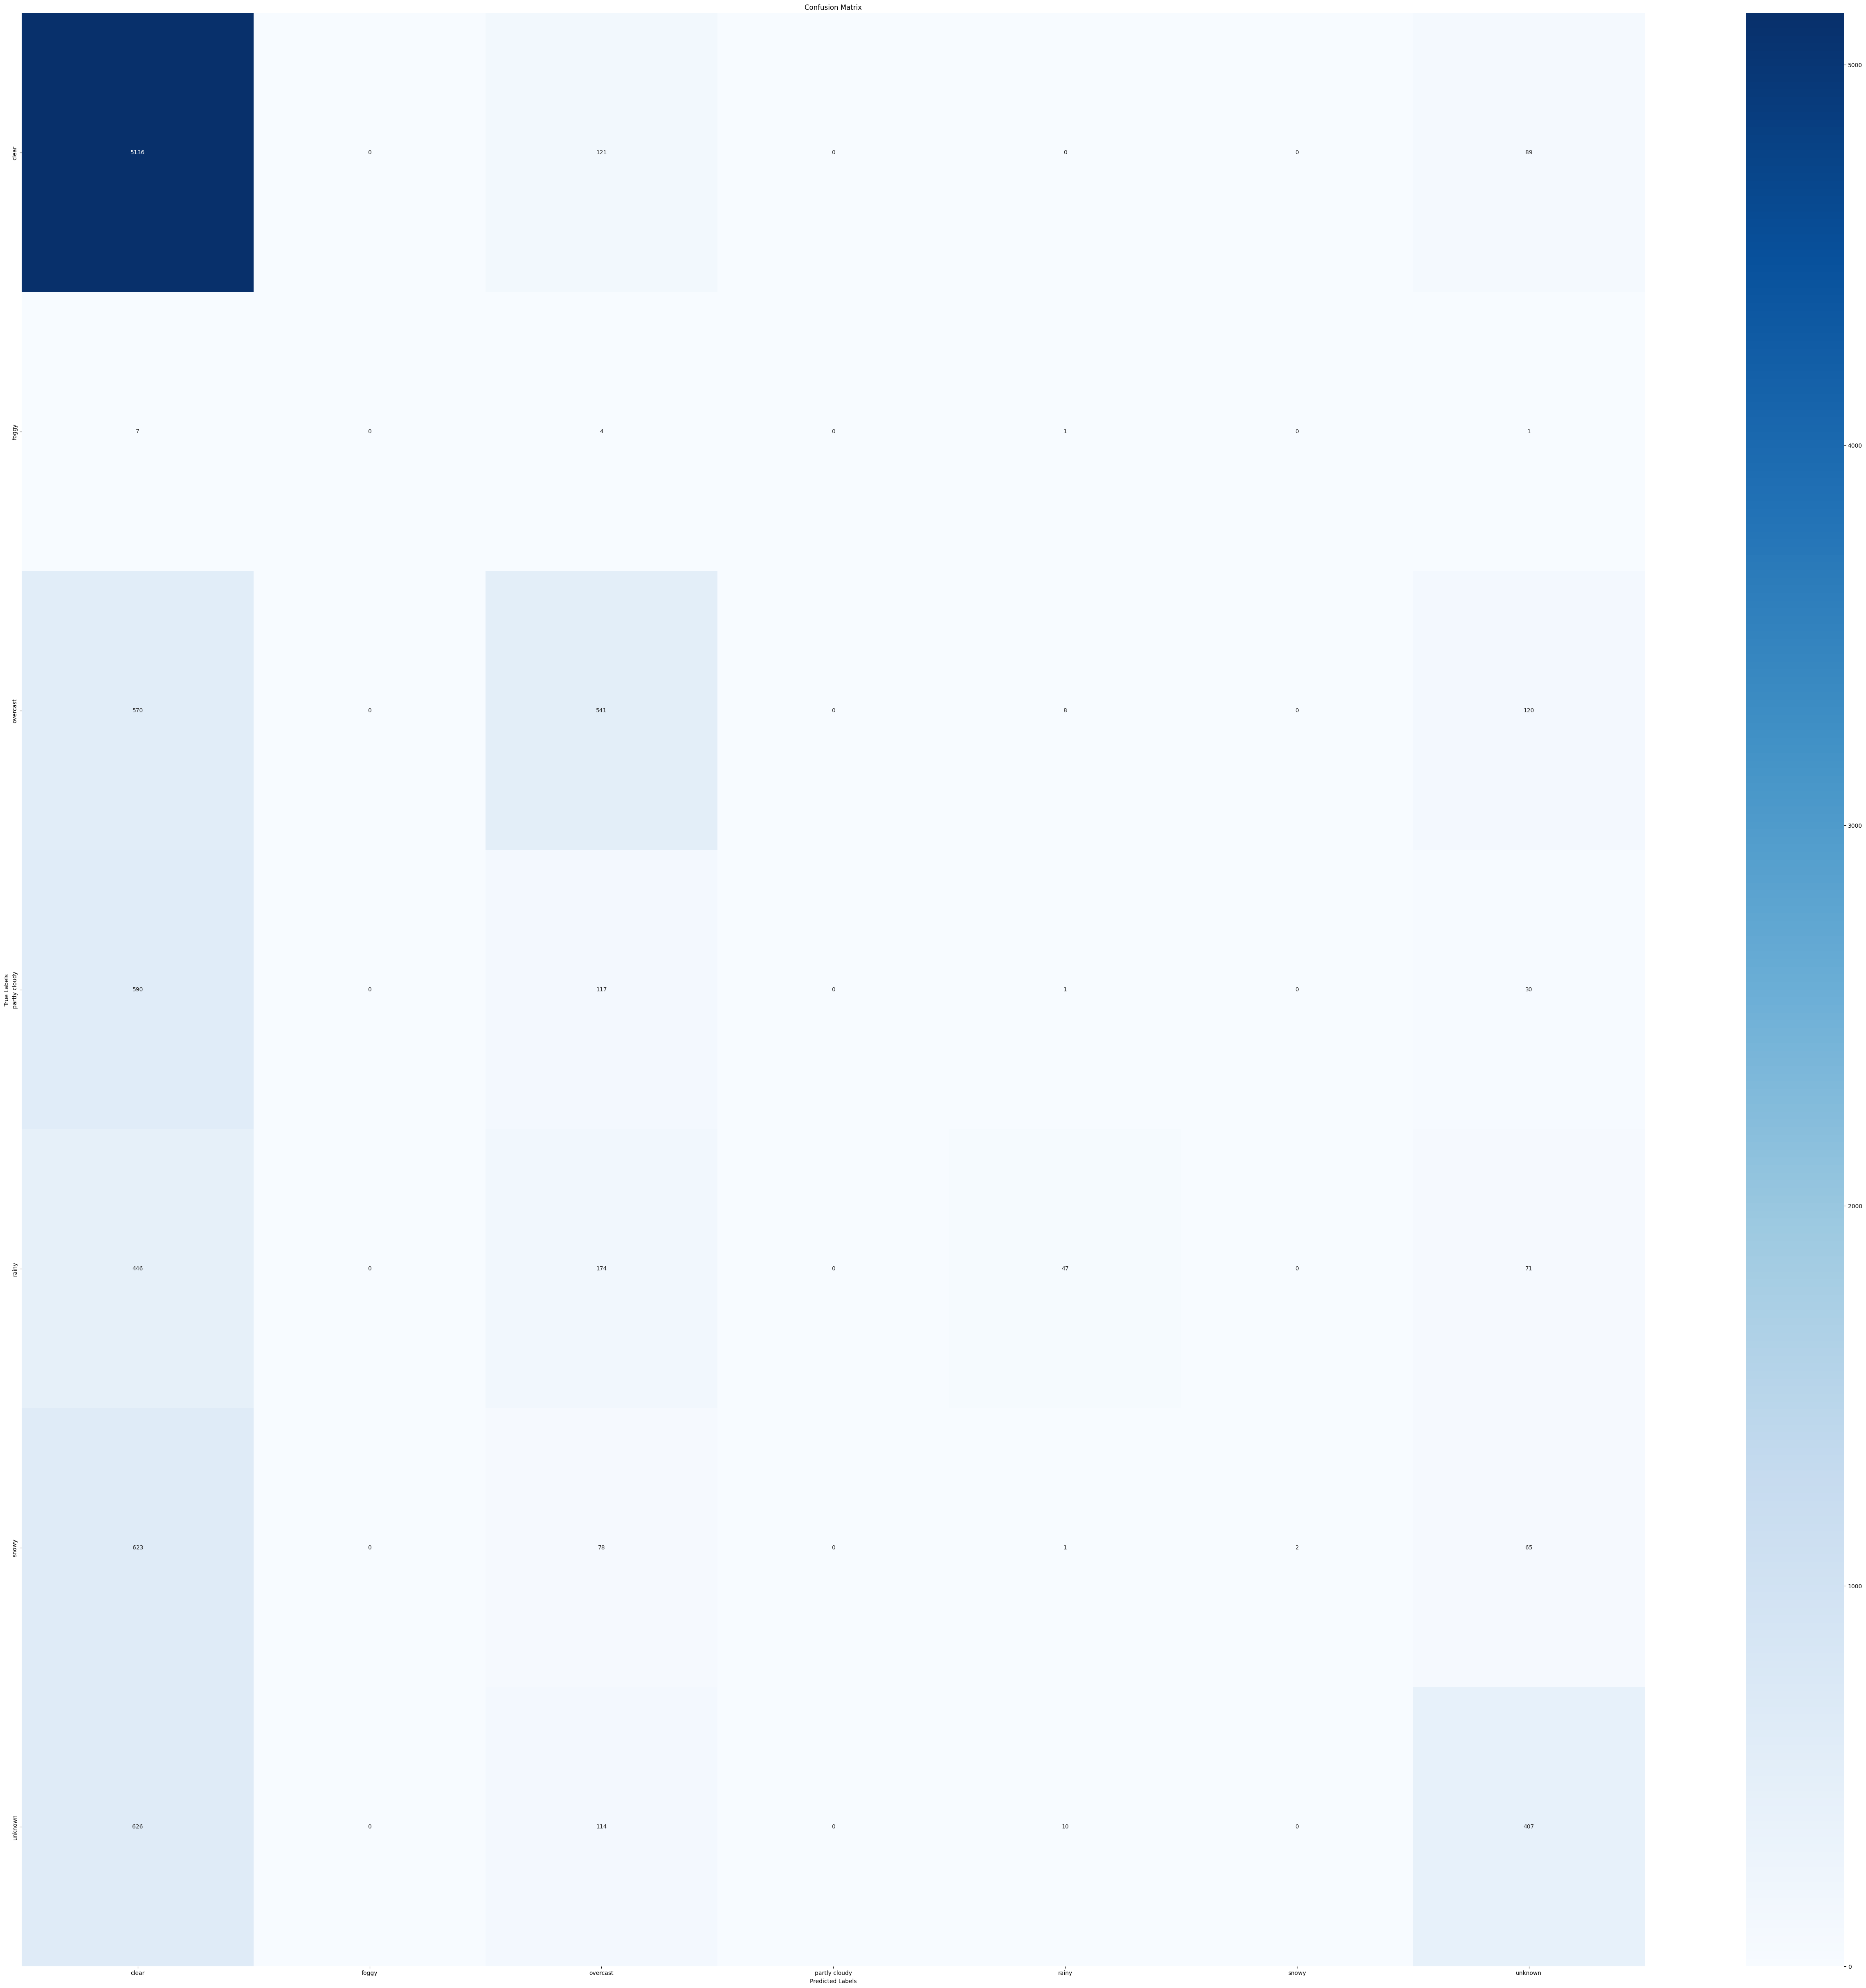

In [26]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix

### If you don't want to train the model again, you can restore it
model.load_state_dict(torch.load(r"C:/Users/partho.ghose/Desktop/Project/Segment/CV2/CNN_weights_full_Weather_Freeze.pth"))
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, dataloader):
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the class index with max probability

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_predictions), np.array(all_labels)

### Get predictions and true labels
predictions, true_labels = get_predictions(model, test_loader)

################# Compute confusion matrix ##################
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

### Calculate accuracy
accuracy = (predictions == true_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

### Plot Confusion Matrix (Optional for Visualization)
import matplotlib.pyplot as plt
import seaborn as sns

# Access the classes from the original dataset (train_dataset)
plt.figure(figsize=(64, 62))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [27]:
# Per-class Performance
class_names = test_dataset.classes  # Ensure 'test_dataset' is correctly defined
print("\nPer-class Performance:")
for i, class_name in enumerate(class_names):
    precision = cm[i, i] / cm[:, i].sum() if cm[:, i].sum() != 0 else 0
    recall = cm[i, i] / cm[i, :].sum() if cm[i, :].sum() != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    print(f"{class_name:15} - Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


Per-class Performance:
clear           - Precision: 0.642, Recall: 0.961, F1: 0.770
foggy           - Precision: 0.000, Recall: 0.000, F1: 0.000
overcast        - Precision: 0.471, Recall: 0.437, F1: 0.453
partly cloudy   - Precision: 0.000, Recall: 0.000, F1: 0.000
rainy           - Precision: 0.691, Recall: 0.064, F1: 0.117
snowy           - Precision: 1.000, Recall: 0.003, F1: 0.005
unknown         - Precision: 0.520, Recall: 0.352, F1: 0.420


### Questions
1. [5 points] What did you observe from the two approaches? Does finetuning really train faster in this case?
2. [5 points] In the above implemetation, the whole model is finetuned to downstream task. Can we just finetune the last fc layer? That is, can we freeze all the weights except the last fc layer during training? Please implement it and analyze the performance.

Obervation: Training the model from scratch resulted in a test accuracy of approximately 70.86%. However, the F1 score, recall, and precision remain low, likely due to training for only 10 epochs.

Observation: 
Using the pre-trained model from Part 1 increased the test accuracy by about 4%, reaching 74.63%. However, since the model in Part 1 did not perform well, using its weights for this task did not provide much benefit. A comparison of both models based on test accuracy, F1 score, recall, and precision shows little difference. Additionally, fine-tuning did not make training any faster, as the training time remained the same. The confusion matrices for both models show a high number of misclassified images, which could be due to training for only 10 epochs.

Fine-tuning only the last fully connected layer while keeping all other layers frozen resulted in even lower performance, with a test accuracy of 61.33%. The confusion matrix shows poor classification results, along with low precision and recall scores. Given the weak performance of the model from Part 1, this outcome was expected, as fine-tuning only the last layer was not enough to improve results.

All three models had low precision, recall, and F1 scores, indicating the need for further improvements. However, when comparing test accuracy, the fully fine-tuned model performed the best, achieving 74.63%.